In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from extract_transform import get_match

In [23]:
# TODO - add docstrings, maybe move functions to modules
def llf(leaf_id): # leaf label func for dendrogram adapted from scipy docs
    """Map leaf_id (index) to Wikidata name
    
    Args:
        leaf_id (int):
    
    Returns:
        leaf_name (str):
    """
    
    leaf_name = wikidata.loc[leaf_id, 'name']
    return leaf_name

# map names based on whether their wikidata desc contains 'chain' and 'restaurant'
def get_color(ylabel): 
    try:
        color = color_dict[ylabel.get_text()]
    except:
        color = 'blue'
    return color

In [2]:
osm_data = pd.read_json('data/preprocessed-osm-data.json.gz')

raw_wikidata = pd.read_json('data/wikidata.json')
preprocessed_wikidata = pd.read_json('data/preprocessed-wikidata.json')
wikidata = raw_wikidata.merge(preprocessed_wikidata, on='qid')

wikidata['name'] = wikidata['names'].apply(lambda names: names[0])
descriptions = wikidata['preprocessed_description']

The aim of this notebook is to identify chain restaurants by determining which Wikidata entries are about chain restaurants and mapping the results back to the OSM data.

In [10]:
contains_chain = wikidata['preprocessed_description'].apply(
    lambda description: get_match('chain', description)
).notna()

contains_restaurant = wikidata['preprocessed_description'].apply(
    lambda description: get_match('restaurant', description)
).notna()
contains_chain_and_restaurant = (contains_chain & contains_restaurant)

wikidata_chain_restaurants = wikidata[contains_chain_and_restaurant]

First, we start off with a regex approach which assumes that a Wikidata entry is about a chain restaurant if its description contains both the words 'chain' and 'restaurant'. 

In [14]:
# get names of chain restaurants that will later be used for dendrogram labels 
chain_restaurant_names = wikidata_chain_restaurants['name'].values
num_chain_restaurant_qids = wikidata_chain_restaurants.shape[0]

# dict with (qid, 1) key value pairs for Wikidata entries related to chain restaurants
chain_restaurant_qids = dict(zip(
    wikidata_chain_restaurants['qid'], 
    np.ones(num_chain_restaurant_qids, dtype=int)
))

# map back to OSM data to get number of chain restaurants so far
num_chain_restaurants = int(osm_data['qid'].map(chain_restaurant_qids).sum())

We check for both 'chain' and 'restaurant' based on how checking for 'chain' alone can potentially result in more false positives since it can also describe non-restaurants.

In [16]:
print('Number of Wikidata Entries about Chain Restaurants: ', end='')
print(num_chain_restaurant_qids)
print(f'Number of Chain Restaurants: {num_chain_restaurants}')

Number of Wikidata Entries about Chain Restaurants: 38
Number of Chain Restaurants: 691


The regex approach considers 38 Wikidata entries to be about chain restaurants and 691 OSM locations to be chain restaurants. Limitations of the regex approach include how it may result in more false negatives and underestimate the number of chain restaurants due to how descriptions for some chain restaurants may not contain both the words 'chain' and 'restaurant'.

In [20]:
# color names associated with wikidata descriptions that contain 'chain' and 'restaurant' red
# -> compare regex predictions with cosine similarity clusters
color_dict = {}
for name in chain_restaurant_names:
    color_dict[name] = 'r'

In [21]:
# calculate cosine similarities between each Wikidata description
vectorizer = CountVectorizer(lowercase=False)
document_term_matrix = vectorizer.fit_transform(descriptions)
cosine_similarities = cosine_similarity(document_term_matrix)

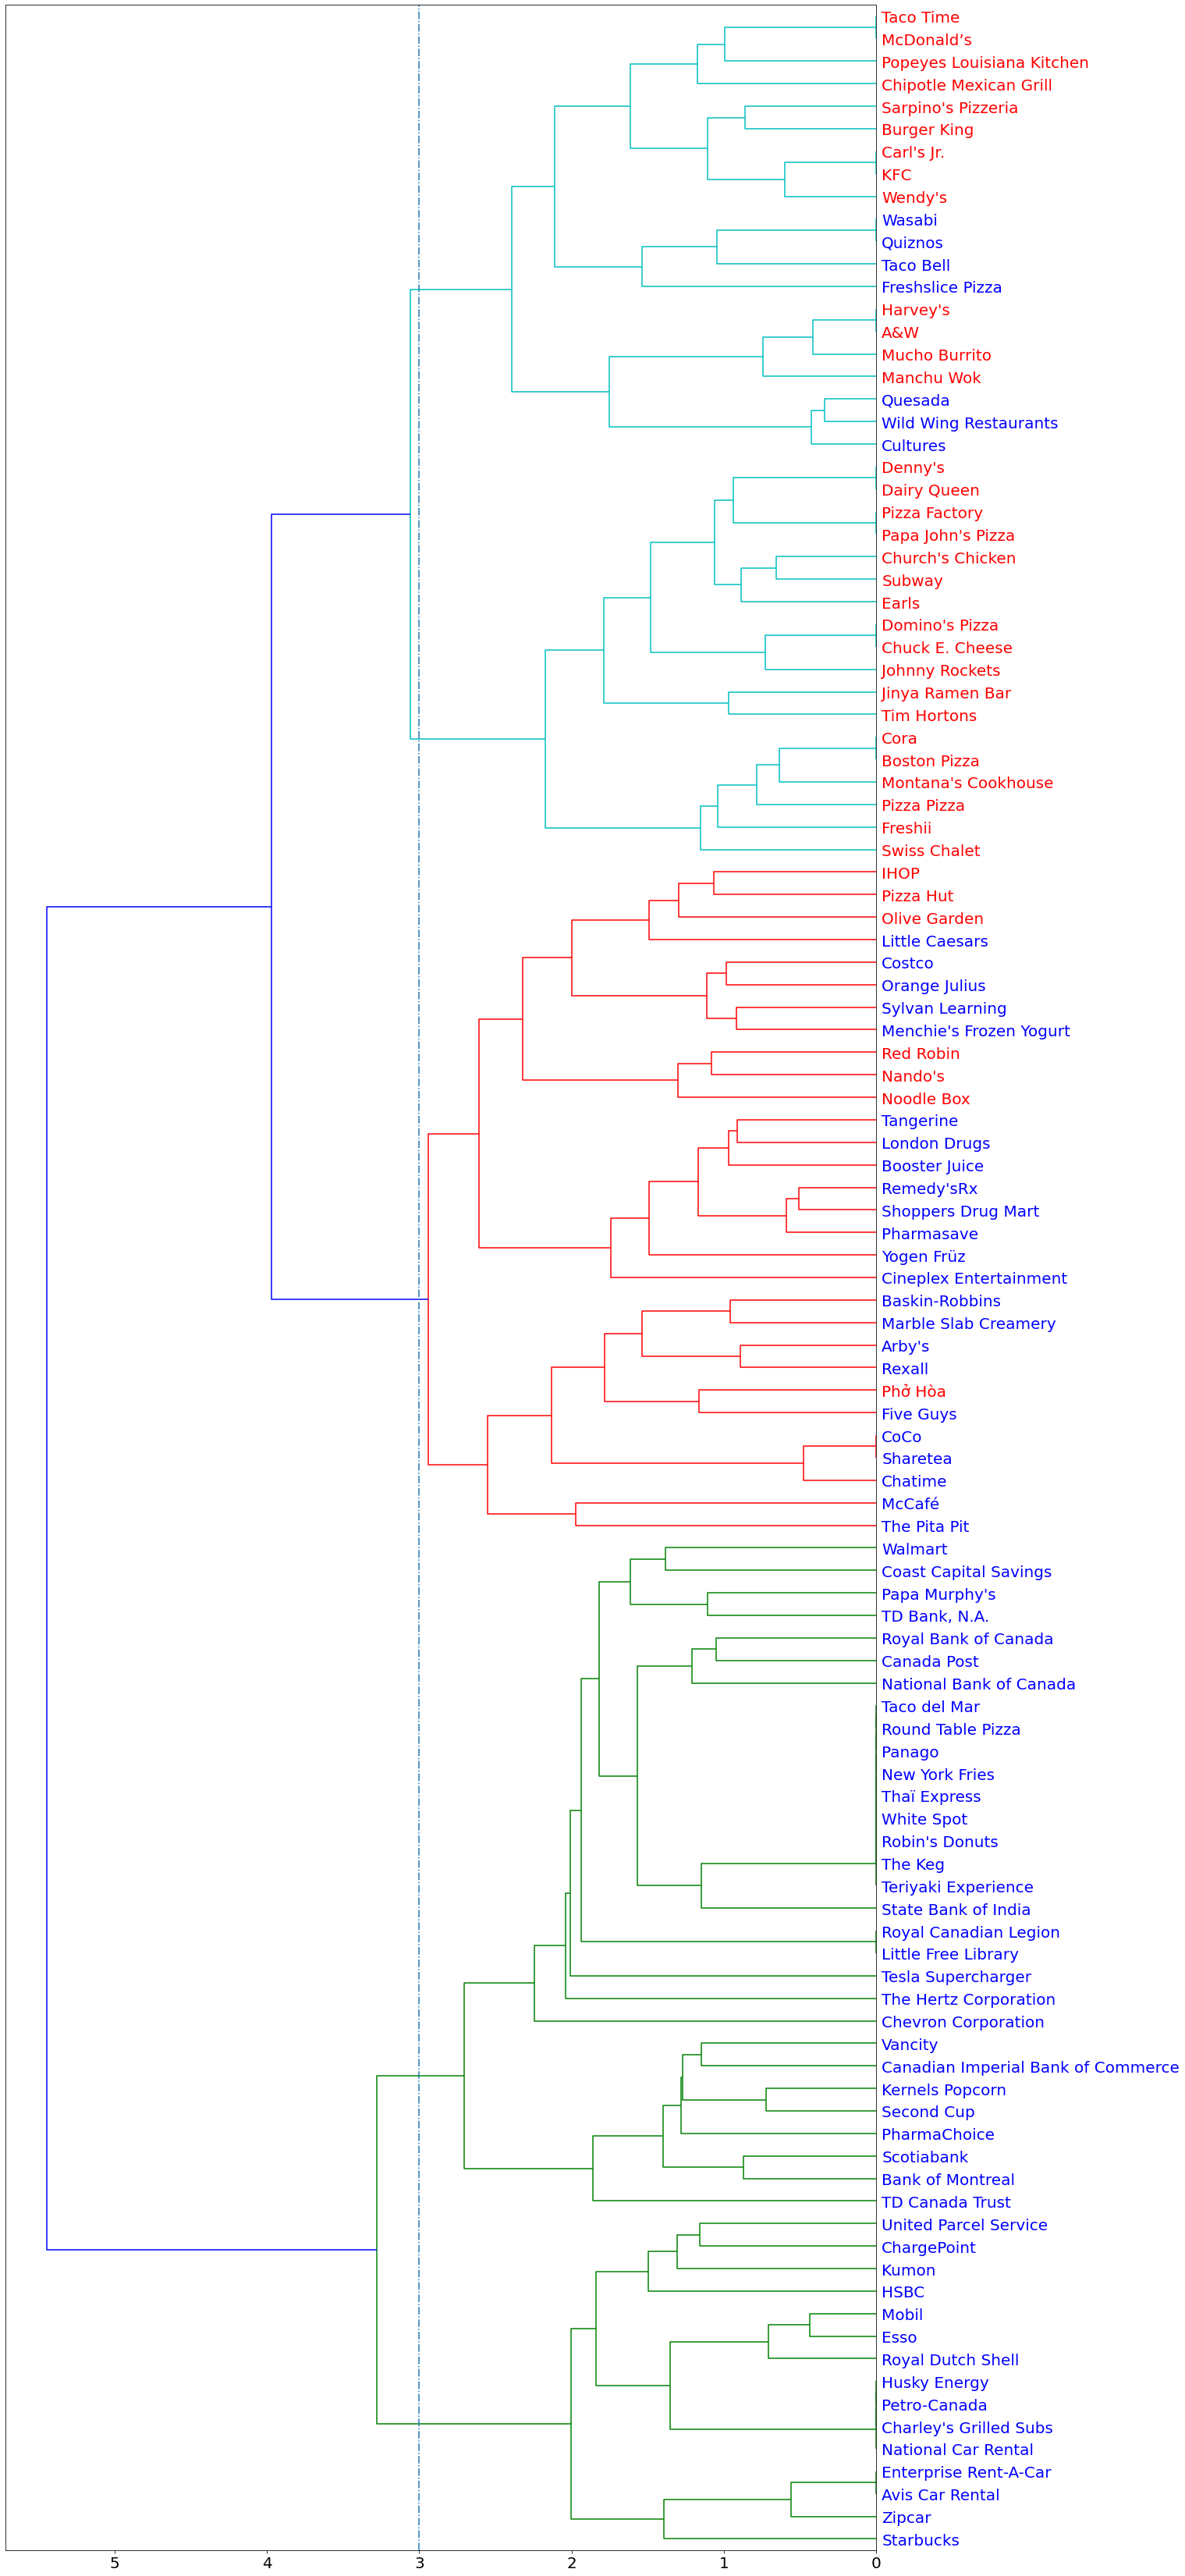

In [26]:
# scipy dendrogram docs
Z = linkage(cosine_similarities, method='complete')

# LOOKS UGLY ON GITLAB USE https://kokes.github.io/nbviewer.js/viewer.html
fig = plt.figure(figsize=(20, 60)) 
dn = dendrogram(Z, leaf_label_func=llf, orientation='left', leaf_font_size=20)

# label coloring adapted from Warren Weckesser's answer at 
# https://stackoverflow.com/questions/14802048/
ax = plt.gca()
ylabels = ax.get_ymajorticklabels()
for ylabel in ylabels:
    ylabel.set_color(get_color(ylabel))
plt.xticks(size=20)
plt.yticks(size=20)
plt.axvline(x=3, linestyle='-.')
plt.show()

In [ ]:
cluster_labels = fcluster(Z, t=4, criterion='maxclust')

In [ ]:
pnames = llf(wikidata.index) # get names given index 

In [ ]:
dict(zip(pnames, cluster_labels)) # dict name and cluster label

In [ ]:
# groupby cluster number, find max freq contains_chain_and_restaurant return cluster number

cluster correctly groups some chain restaurants with descriptions that do not contain the words
'chain' or 'restaurant'